In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
import dask.dataframe as dd
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
goslim_all_human = dd.read_csv('../data/biomart_goslim/biomart_human_goslim_R110_extract.tsv', sep='\t')
goslim_all_rice = dd.read_csv('../data/biomart_goslim/biomart_rice_goslim_R56_extract.tsv', sep='\t')

display(goslim_all_human)
display(goslim_all_rice)

,Gene stable ID,GOSlim GOA Accession(s),GOSlim GOA Description
npartitions=1,,,
,object,object,object
,...,...,...


,Gene stable ID,GOSlim GOA Accession(s),GOSlim GOA Description
npartitions=1,,,
,object,object,object
,...,...,...


In [3]:
# merge dataframe based on common column 'GOSlim GOA Accession(s)'
merged_df_goslim = dd.merge(
    goslim_all_human, 
    goslim_all_rice,
    left_on=['GOSlim GOA Accession(s)', 'GOSlim GOA Description'],
    right_on=['GOSlim GOA Accession(s)','GOSlim GOA Description'],
    how='inner',
    suffixes=('_rice', '_human')
)

# extract necessary columns
merged_df_goslim = merged_df_goslim[['GOSlim GOA Accession(s)',
                                     'GOSlim GOA Description',
                                     'Gene stable ID_human',
                                     'Gene stable ID_rice'
                                     ]]

merged_df_goslim_pd = merged_df_goslim.compute()

# Remove duplicate rows based on specific columns
merged_df_goslim_pd.drop_duplicates(inplace=True)

# for debugging purpose
unique_accessions_r = set(goslim_all_human['GOSlim GOA Accession(s)'].compute().unique())
unique_accessions_h = set(goslim_all_rice['GOSlim GOA Accession(s)'].compute().unique())
common_accessions = unique_accessions_r.intersection(unique_accessions_h)
unique_accessions_merged = set(merged_df_goslim_pd['GOSlim GOA Accession(s)'].unique())
missing_accessions = common_accessions.difference(unique_accessions_merged)
duplicates = merged_df_goslim_pd.duplicated(subset=['GOSlim GOA Accession(s)','Gene stable ID_rice', 'Gene stable ID_human'], keep=False)
unique_combinations = not duplicates.any()
print(f"Number of common accessions: {len(common_accessions)}")
print(f"Number of missing accessions: {len(missing_accessions)}")
print(f"Missing accessions: {missing_accessions}")
print(f"各'Gene stable ID_rice'と'Gene stable ID_human'の組み合わせはユニークですか？: {unique_combinations}")

merged_df_goslim_pd.to_csv("../data/common_goslim_correspondence_all.tsv", sep='\t', index=False)

display(merged_df_goslim_pd)

Number of common accessions: 34
Number of missing accessions: 0
Missing accessions: set()
各'Gene stable ID_rice'と'Gene stable ID_human'の組み合わせはユニークですか？: True


,GOSlim GOA Accession(s),GOSlim GOA Description,Gene stable ID_human,Gene stable ID_rice
0,GO:0005886,plasma membrane,Os01g0100400,ENSG00000186092
1,GO:0005886,plasma membrane,Os01g0103600,ENSG00000186092
2,GO:0005886,plasma membrane,Os01g0104000,ENSG00000186092
3,GO:0005886,plasma membrane,Os01g0108000,ENSG00000186092
4,GO:0005886,plasma membrane,Os01g0110100,ENSG00000186092
...,...,...,...,...
851735770,GO:0045182,translation regulator activity,Os12g0507200,ENSG00000205916
851735771,GO:0045182,translation regulator activity,Os12g0541500,ENSG00000205916
851735776,GO:0045182,translation regulator activity,Os12g0607100,ENSG00000205916
851735778,GO:0045182,translation regulator activity,Os12g0617100,ENSG00000205916


In [4]:
def count_goslim(df, file_name: str):
    unique_gene_pairs = df.drop_duplicates(subset=['GOSlim GOA Accession(s)', 'Gene stable ID_human', 'Gene stable ID_rice'])
    goslim_counts = unique_gene_pairs.groupby(['GOSlim GOA Accession(s)', 'GOSlim GOA Description']).size().reset_index(name='counts')
    goslim_counts = goslim_counts.sort_values(by='counts', ascending=False).copy()
    results_directory = './goslim_correspondence_counts'
    os.makedirs(results_directory, exist_ok=True)
    goslim_counts.to_csv(f'{results_directory}/{file_name}', sep='\t', index=False)
    return goslim_counts

In [5]:
merged_df_up = pd.read_csv('../data/circos_result_UP_2311/merged_goslim_sorted_UP.tsv', sep='\t')
display(merged_df_up)

,GOSlim GOA Accession(s),GOSlim GOA Description,Gene stable ID_rice,Gene stable ID_human,Chromosome/scaffold name_rice,start1 (bp),end1 (bp),Chromosome/scaffold name_human,start2 (bp),end2 (bp),HN-score(HN5)_rice,HN-score(HN5)_human
0,GO:0003824,catalytic activity,Os12g0106000,ENSG00000178297,R_12,320568,323716,H_19,2360238,2426261,47,72
1,GO:0003824,catalytic activity,Os02g0630300,ENSG00000144381,R_2,25199505,25203742,H_2,197486584,197516737,58,55
2,GO:0003824,catalytic activity,Os05g0200500,ENSG00000188536,R_5,6273311,6282541,H_16,172876,173710,57,139
3,GO:0003824,catalytic activity,Os05g0200500,ENSG00000204390,R_5,6273311,6282541,H_6,31809619,31815283,57,150
4,GO:0003824,catalytic activity,Os05g0200500,ENSG00000166592,R_5,6273311,6282541,H_16,66921685,66925535,57,155
...,...,...,...,...,...,...,...,...,...,...,...,...
15167,GO:0005198,structural molecule activity,Os01g0105800,ENSG00000112110,R_1,306871,308842,H_6,159789812,159798436,53,63
15168,GO:0005777,peroxisome,Os06g0253100,ENSG00000165507,R_6,7940956,7941680,H_10,44970981,44978809,129,70
15169,GO:0005777,peroxisome,Os07g0529000,ENSG00000165507,R_7,20691213,20693521,H_10,44970981,44978809,59,70
15170,GO:0005840,ribosome,Os11g0303800,ENSG00000112110,R_11,11436951,11446262,H_6,159789812,159798436,65,63


In [6]:
gosilm_correspondence_up_counts = count_goslim(merged_df_up, 'goslim_correspondence_counts_UP.tsv')
goslim_correspondence_all_counts = count_goslim(merged_df_goslim_pd, 'goslim_correspondence_counts_all.tsv')

display(gosilm_correspondence_up_counts)
display(goslim_correspondence_all_counts)

,GOSlim GOA Accession(s),GOSlim GOA Description,counts
2,GO:0003824,catalytic activity,4136
6,GO:0005634,nucleus,3550
14,GO:0005829,cytosol,1248
23,GO:0016787,hydrolase activity,912
27,GO:0048856,anatomical structure development,819
17,GO:0005886,plasma membrane,676
5,GO:0005576,extracellular region,600
12,GO:0005783,endoplasmic reticulum,588
0,GO:0003677,DNA binding,546
25,GO:0036211,protein modification process,418


,GOSlim GOA Accession(s),GOSlim GOA Description,counts
3,GO:0003824,catalytic activity,62834292
7,GO:0005634,nucleus,50586355
21,GO:0005886,plasma membrane,14121523
30,GO:0036211,protein modification process,11265607
26,GO:0016740,transferase activity,10856023
27,GO:0016787,hydrolase activity,8674587
18,GO:0005829,cytosol,7811118
32,GO:0048856,anatomical structure development,7216908
0,GO:0003677,DNA binding,5819761
1,GO:0003723,RNA binding,4482192


In [7]:
# for debugging purpose
total_counts_up = gosilm_correspondence_up_counts['counts'].sum()
total_counts_all = goslim_correspondence_all_counts['counts'].sum()


unique_rows_up = merged_df_up.drop_duplicates(subset=['GOSlim GOA Accession(s)', 'Gene stable ID_human', 'Gene stable ID_rice']).shape[0]
unique_rows_all = merged_df_goslim_pd.drop_duplicates(subset=['GOSlim GOA Accession(s)', 'Gene stable ID_human', 'Gene stable ID_rice']).shape[0]

print(f"Total counts: {unique_rows_all}")
print(f"up counts: {unique_rows_up}")
print(f"Counts match rows: {unique_rows_up == total_counts_up}")


Total counts: 205962891
up counts: 15172
Counts match rows: True


In [8]:

def fold_enrichment(df_goslim_up_counts, df_goslim_all_counts, unique_genes_up, unique_genes_all, file_name: str):
    """_summary_
    Args:
        df_goslim_up_counts (dataframe): _description_
        df_goslim_all_counts (dataframe): _description_
        unique_genes_up (): _description_
        unique_genes_all (dataframe): _description_
        file_name (str): _description_

    Returns:
        dataframe : _description_
    """
    merged_df = pd.merge(df_goslim_up_counts, 
                         df_goslim_all_counts,
                         on=['GOSlim GOA Accession(s)', 'GOSlim GOA Description'], 
                         how='right', # if there is no match, fill with NaN or 0
                         suffixes=('_up', '_all'))
    
    merged_df['counts_up'] = merged_df['counts_up'].fillna(0)
    merged_df['counts_all'] = merged_df['counts_all'].fillna(0)
    merged_df['up_ratio'] = merged_df['counts_up'] / unique_genes_up
    merged_df['all_ratio'] = merged_df['counts_all'] / unique_genes_all
    merged_df['fold_enrichment'] = merged_df['up_ratio'] / merged_df['all_ratio']
    merged_df.replace([np.inf, -np.inf], np.nan, inplace=True) # inf -> nan
    results_directory = './goslim_fold_enrichment_correspondence'
    os.makedirs(results_directory, exist_ok=True)
    merged_df.to_csv(f'{results_directory}/{file_name}', sep='\t', index=False)
    
    return merged_df


goslim_correspondence_enrichment = fold_enrichment(gosilm_correspondence_up_counts, goslim_correspondence_all_counts, unique_rows_up, unique_rows_all, 'goslim_correspondence_fold_enrichment.tsv')
display(goslim_correspondence_enrichment)

,GOSlim GOA Accession(s),GOSlim GOA Description,counts_up,counts_all,up_ratio,all_ratio,fold_enrichment
0,GO:0003824,catalytic activity,4136.0,62834292,0.272607,0.305076,0.893573
1,GO:0005634,nucleus,3550.0,50586355,0.233984,0.245609,0.952667
2,GO:0005886,plasma membrane,676.0,14121523,0.044556,0.068563,0.649847
3,GO:0036211,protein modification process,418.0,11265607,0.027551,0.054697,0.503695
4,GO:0016740,transferase activity,204.0,10856023,0.013446,0.052709,0.255097
5,GO:0016787,hydrolase activity,912.0,8674587,0.060111,0.042117,1.427224
6,GO:0005829,cytosol,1248.0,7811118,0.082257,0.037925,2.168940
7,GO:0048856,anatomical structure development,819.0,7216908,0.053981,0.035040,1.540561
8,GO:0003677,DNA binding,546.0,5819761,0.035987,0.028256,1.273602
9,GO:0003723,RNA binding,170.0,4482192,0.011205,0.021762,0.514878


## Q-value

In [9]:

def calculate_p_q_values(df_enrichment, unique_correspondence_up, unique_correspondence_all, file_name: str):
    p_values = []
    df_enrichment['counts_up'] = df_enrichment['counts_up'].astype(int) # float(0.0) to int(0)
    for index, row in df_enrichment.iterrows():
        if row['counts_up'] == 0:
            p_values.append(1.0)
        else:
            observed_up_correspondence = row['counts_up'] # create contingency table
            observed_all_correspondence = row['counts_all']
            observed_not_up_correspondence = observed_all_correspondence - observed_up_correspondence
            total_not_up_correspondence = unique_correspondence_all - unique_correspondence_up
            table = [
            [observed_up_correspondence, unique_correspondence_up - observed_up_correspondence],
            [observed_not_up_correspondence, total_not_up_correspondence - observed_not_up_correspondence]
            ]
            _, p_value = fisher_exact(table, alternative='greater') # Fisher's exact test
            p_values.append(p_value)
    
    _, q_values, _, _ = multipletests(p_values, 
                                      alpha=0.05, 
                                      method='fdr_bh') # Benjamini/Hochberg method
    
    df_enrichment['p_value'] = p_values
    df_enrichment['q_value'] = q_values

    results_directory = './goslim_correspondence_q_values'
    os.makedirs(results_directory, exist_ok=True)
    df_enrichment['GOSlim'] = df_enrichment['GOSlim GOA Accession(s)'] + ": " + df_enrichment['GOSlim GOA Description']
    cols = df_enrichment.columns.tolist()
    cols = [cols[-1]] + cols[:-1]
    df_enrichment = df_enrichment[cols]
    df_enrichment.drop(['GOSlim GOA Accession(s)', 'GOSlim GOA Description'], axis=1, inplace=True)
    df_enrichment = df_enrichment[df_enrichment['counts_up'] != 0]
    df_enrichment = df_enrichment.sort_values(by='fold_enrichment', ascending=False)
    df_enrichment.to_csv(f'{results_directory}/{file_name}', sep='\t', index=False)

    return df_enrichment

goslim_correspondence_with_p_q = calculate_p_q_values(goslim_correspondence_enrichment,
                                                      unique_rows_up,
                                                      unique_rows_all, 
                                                      'goslim_correspondence_fold_enrichment_p_q.tsv')

display(goslim_correspondence_with_p_q)

/var/folders/7w/6nt3szxj44xdr5xs8y9g8lhw0000gn/T/ipykernel_1354/917236854.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_enrichment.drop(['GOSlim GOA Accession(s)', 'GOSlim GOA Description'], axis=1, inplace=True)


,GOSlim,counts_up,counts_all,up_ratio,all_ratio,fold_enrichment,p_value,q_value
14,GO:0005783: endoplasmic reticulum,588,1919256,0.038756,0.009318,4.159016,2.539107e-175,8.632965e-174
25,GO:0006091: generation of precursor metabolite...,55,265631,0.003625,0.001290,2.810801,3.966800e-11,1.685890e-10
26,GO:0008289: lipid binding,49,257535,0.003230,0.001250,2.582890,6.223319e-09,2.351032e-08
11,GO:0140110: transcription regulator activity,396,2256826,0.026101,0.010957,2.382008,1.889550e-52,1.606117e-51
6,GO:0005829: cytosol,1248,7811118,0.082257,0.037925,2.168940,8.805413e-137,1.496920e-135
10,GO:0005576: extracellular region,600,3845282,0.039547,0.018670,2.118211,9.704598e-62,1.099854e-60
12,GO:0005739: mitochondrion,280,1951236,0.018455,0.009474,1.948024,3.221263e-24,1.564614e-23
20,GO:0005975: carbohydrate metabolic process,84,676139,0.005537,0.003283,1.686512,5.992973e-06,1.852373e-05
7,GO:0048856: anatomical structure development,819,7216908,0.053981,0.035040,1.540561,2.844564e-32,1.934304e-31
32,GO:0005777: peroxisome,2,18172,0.000132,0.000088,1.494078,3.868057e-01,1.000000e+00


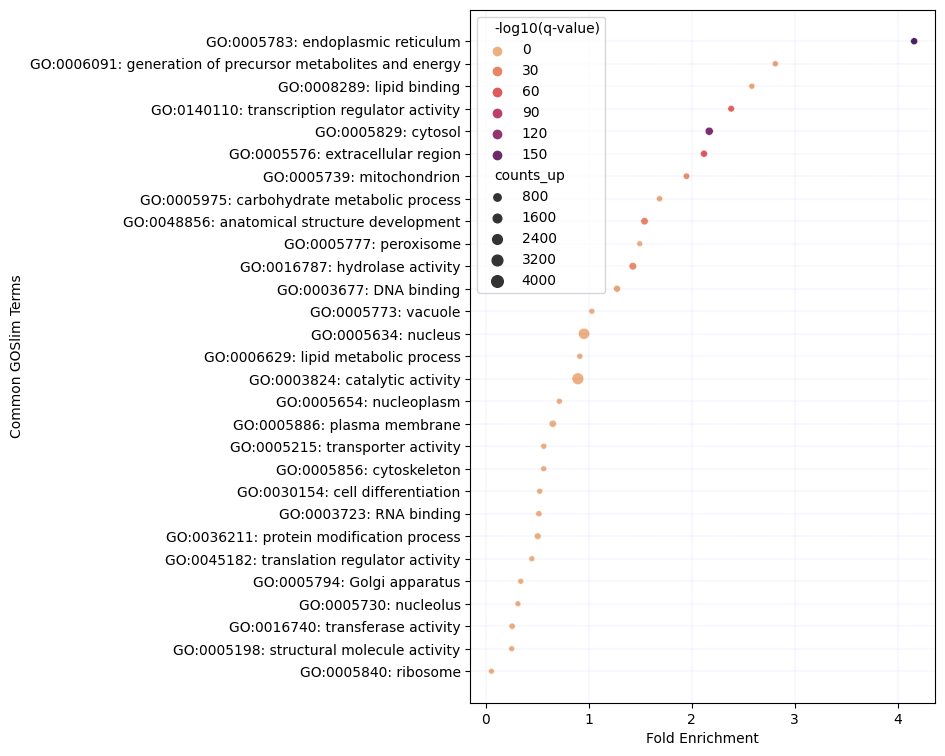

In [12]:
color = sns.color_palette("flare", as_cmap=True)

goslim_correspondence_with_p_q['-log10(q-value)'] = -np.log10(goslim_correspondence_with_p_q['q_value'])

plt.figure(figsize=(6, 9))

dotplot = sns.scatterplot(
    data=goslim_correspondence_with_p_q,
    x='fold_enrichment',
    y='GOSlim',
    size='counts_up', 
    hue='-log10(q-value)' ,     
    palette=color, 
    legend='brief'
)

plt.grid(color='b', linestyle=':', linewidth=0.1)

plt.xlabel('Fold Enrichment')
plt.ylabel('Common GOSlim Terms')



plt.show()